In [1]:
%reset -f

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pywt.data

In [3]:
x = tf.constant(pywt.data.camera().astype(np.float32))[tf.newaxis,:,:,tf.newaxis]
x/=255
tf.reduce_min(x),tf.reduce_max(x)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [4]:
N1,N2=x.shape[1],x.shape[2]
N1,N2

(512, 512)

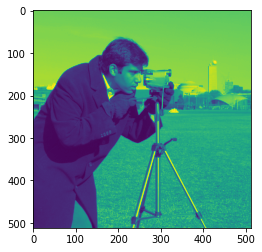

In [5]:
plt.imshow(x[0,:,:,0]);

In [6]:
x_ft=tf.signal.rfft(x[0,:,:,0])
x_ft.shape


TensorShape([512, 257])

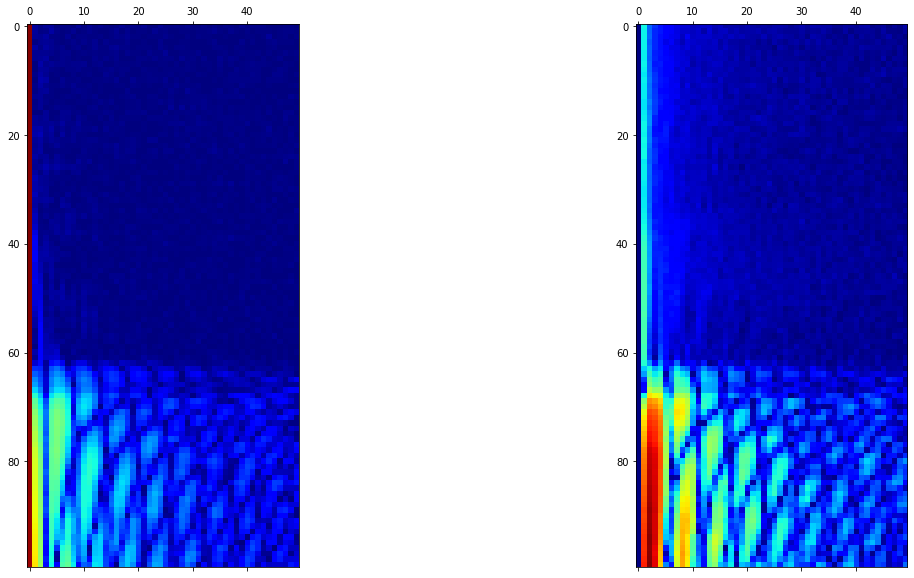

In [15]:
fig,axs=plt.subplots(1,2,figsize=(20,10))
axs[0].matshow(tf.math.log(1+tf.abs(tf.math.real(x_ft[:100,:50]))),cmap="jet")
axs[1].matshow(tf.math.log(1+tf.abs(tf.math.imag(x_ft[:100,:50]))),cmap="jet")

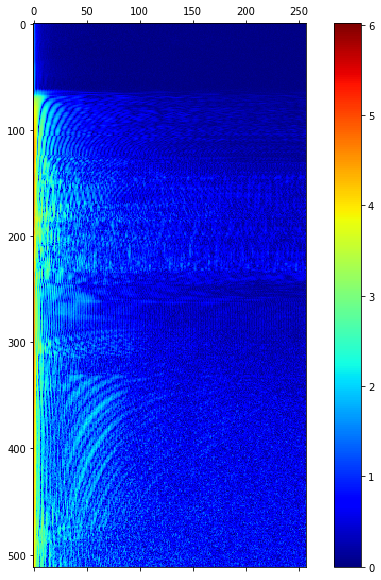

In [16]:
fig,ax=plt.subplots(figsize=(10,10))
res=ax.matshow(tf.math.log(1+tf.abs(x_ft)),cmap="jet")
plt.colorbar(res)

In [10]:
tf.ones([10,10],dtype=tf.complex64)

<tf.Tensor: shape=(10, 10), dtype=complex64, numpy=
array([[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
        1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
        1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
        1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
        1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
        1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
        1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
        1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
        1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
        1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
   

In [11]:
class SpectralConv2d(tf.keras.layers.Layer):

    def __init__(self, in_channels, out_channels, modes1,modes2):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.weights1  = self.get_complex_weights_2d(in_channels,out_channels)
        self.weights2  = self.get_complex_weights_2d(in_channels,out_channels)

    def get_complex_weights_2d_old(self,in_channels,out_channels):
        scale = (1 / (in_channels*out_channels))
        real = tf.cast(tf.random.uniform([in_channels, out_channels, self.modes1,self.modes2]), tf.complex64)
        img  = tf.cast(tf.random.uniform([in_channels, out_channels, self.modes1,self.modes2]), tf.complex64)
        sqrt_1 = tf.constant(1.j, dtype=tf.complex64)
        return tf.Variable(scale * (real + sqrt_1 * img))

    def get_complex_weights_2d(self,in_channels,out_channels):
        return tf.ones([in_channels, out_channels, self.modes1,self.modes2],dtype=tf.complex64)

    
    # Complex multiplication
    def compl_mul2d(self, inputs, weights):
        # (batch, in_channel, nx,ny ), (in_channel, out_channel, nx) -> (batch, out_channel, ny)
        return tf.einsum("bixy,ioxy->boxy", inputs, weights)

    @tf.function
    def call(self, A):

        #on met les 2 axes d'espace en dernier, car rfft2d agit sur les 2 derniers axies
        A=tf.transpose(A, [0, 3, 1, 2])

        #Compute Fourier coeffcients
        A_ft = tf.signal.rfft2d(A)  # shape=(...,A.shape[-2],A.shape[-1]//2+1)

        """
        Attention au rfft
        [1,1,n1,10]=> [1,1,n1,6]
        [1,1,n1,9]=>  [1,1,n1,5]
        """

        # Multiply relevant Fourier modes
        out_ft_corner_SO = self.compl_mul2d(A_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft_corner_NO = self.compl_mul2d(A_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        out_ft_corner_SO =tf.pad(out_ft_corner_SO,[[0,0],[0,0],[0,A.shape[2] - self.modes1], [0,A_ft.shape[3] - self.modes2]])
        out_ft_corner_NO =tf.pad(out_ft_corner_NO,[[0,0],[0,0],[A.shape[2]  - self.modes1,0],[0,A_ft.shape[3] - self.modes2]])
        out_ft=out_ft_corner_SO+out_ft_corner_NO
        #Return to physical space
        A = tf.signal.irfft2d(out_ft, fft_length=[A.shape[2],A.shape[3]]) #fft_length=

        #on remet l'axe des channel en dernier
        A=tf.transpose(A, [0, 2, 3, 1])

        return A

In [12]:
in_channels, out_channels, modes1,modes2=1,1,60,60
N1_out,N2_out=400,100
spectral_conv=SpectralConv2d(in_channels, out_channels, modes1,modes2)
x_filter=spectral_conv.call(x)
x_filter.shape,tf.reduce_min(x_filter),tf.reduce_max(x_filter)

(TensorShape([1, 512, 512, 1]),
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.07343209>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1268563>)

In [13]:
%%time
for _ in range(500):
    spectral_conv.call(x)

CPU times: user 476 ms, sys: 163 ms, total: 638 ms
Wall time: 848 ms


In [50]:
class SpectralConv2d_real(tf.keras.layers.Layer):

    def __init__(self, in_channels, out_channels, modes1,modes2,N1_out,N2_out,mix_frequencies=True):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.N1_out=N1_out
        self.N2_out=N2_out
        self.mix_frequencies=mix_frequencies

        self.weights1  = self.get_complex_weights_2d(in_channels,out_channels)
        self.weights2  = self.get_complex_weights_2d(in_channels,out_channels)

        
        if self.mix_frequencies:
            self.mobil_weights_real_NO=tf.Variable(self.get_mobil_weights())
            self.mobil_weights_imag_NO=tf.Variable(self.get_mobil_weights())
            self.mobil_weights_real_SO=tf.Variable(self.get_mobil_weights())
            self.mobil_weights_imag_SO=tf.Variable(self.get_mobil_weights())


    def get_mobil_weights(self):
            filter=np.zeros([2,2,1,1]).astype(np.float32)
            filter[0,0,0,0]=1
            return tf.constant(filter)


    def get_complex_weights_2d(self,in_channels,out_channels):#TODO
        return tf.ones([in_channels, out_channels, self.modes1,self.modes2])

    
    # Complex multiplication
    def compl_mul2d(self, inputs, weights):
        # (batch, in_channel, nx,ny ), (in_channel, out_channel, nx) -> (batch, out_channel, ny)
        return tf.einsum("bixy,ioxy->boxy", inputs, weights)


    @tf.function
    def call(self, A):
        _,N1,N2,_=A.shape

        #on met les 2 axes d'espace en dernier, car rfft2d agit sur les 2 derniers axies
        A=tf.transpose(A, [0, 3, 1, 2])

        #Compute Fourier coeffcients
        B = tf.signal.rfft2d(A)/N1/N2  # shape=(...,A.shape[-2],A.shape[-1]//2+1)


        B_real=tf.math.real(B)
        B_imag=tf.math.imag(B)

        C_real=self.one_part(B_real,True)
        C_imag=self.one_part(B_imag,False)

        C=tf.complex(C_real,C_imag)

        #Return to physical space
        A = tf.signal.irfft2d(C, fft_length=[self.N1_out,self.N2_out])*self.N1_out*self.N2_out

        #on remet l'axe des channel en dernier
        A=tf.transpose(A, [0, 2, 3, 1])

        return A

    def conv(self,X,mobil_weights):
        return tf.nn.conv2d(input=X,filters=mobil_weights,strides=(1,1),padding="SAME",data_format='NCHW')


    def one_part(self,B,is_real):
        # Multiply relevant Fourier modes

        #B_pool=tf.nn.max_pool2d(B, ksize=(2,2), strides=(2,2), padding="SAME",data_format="NCHW")

        out_ft_corner_SO = self.compl_mul2d(B[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft_corner_NO = self.compl_mul2d(B[:, :, -self.modes1:, :self.modes2], self.weights2)
        
        if self.mix_frequencies:
            out_ft_corner_SO=self.conv(out_ft_corner_SO,self.mobil_weights_real_SO if is_real else self.mobil_weights_imag_SO)
            out_ft_corner_NO=self.conv(out_ft_corner_NO,self.mobil_weights_real_NO if is_real else self.mobil_weights_imag_NO)

        out_ft_corner_SO =tf.pad(out_ft_corner_SO,[[0,0],[0,0],[0,self.N1_out - self.modes1], [0,self.N2_out - self.modes2]])
        out_ft_corner_NO =tf.pad(out_ft_corner_NO,[[0,0],[0,0],[self.N1_out  - self.modes1,0],[0,self.N2_out - self.modes2]])
        return out_ft_corner_SO+out_ft_corner_NO

In [51]:
X=np.random.choice([1,2,3,4,5],size=[1,1,10,10])
X

array([[[[3, 5, 3, 1, 2, 3, 2, 4, 3, 1],
         [2, 1, 2, 5, 4, 2, 3, 2, 2, 4],
         [1, 1, 3, 5, 4, 4, 2, 4, 1, 1],
         [2, 2, 1, 3, 5, 1, 4, 5, 5, 2],
         [5, 3, 2, 5, 3, 4, 3, 1, 1, 1],
         [2, 4, 3, 4, 2, 5, 3, 5, 3, 4],
         [1, 5, 2, 4, 2, 1, 1, 2, 1, 5],
         [3, 1, 5, 3, 3, 5, 1, 1, 3, 5],
         [3, 3, 3, 1, 1, 4, 5, 1, 5, 3],
         [1, 2, 1, 1, 3, 1, 5, 5, 3, 3]]]])

In [52]:
in_channels, out_channels, modes1,modes2=1,1,100,100
N1_out,N2_out=400,400
model=SpectralConv2d_real(in_channels, out_channels, modes1,modes2,N1_out,N2_out)
res=model.conv(X,model.mobil_weights_imag_NO)
res-X

<tf.Tensor: shape=(1, 1, 10, 10), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=float32)>

In [53]:
in_channels, out_channels, modes1,modes2=1,1,100,100
N1_out,N2_out=400,400
spectral_conv=SpectralConv2d_real(in_channels, out_channels, modes1,modes2,N1_out,N2_out)
x_filter=spectral_conv.call(x)
x_filter.shape,tf.reduce_min(x_filter),tf.reduce_max(x_filter)

(TensorShape([1, 400, 400, 1]),
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.0866701>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.1013609>)

In [54]:
%%time
for _ in range(500):
    spectral_conv.call(x)

CPU times: user 687 ms, sys: 167 ms, total: 854 ms
Wall time: 865 ms


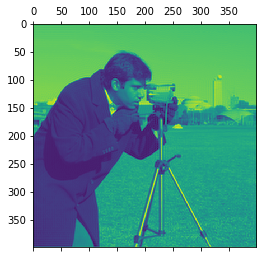

In [55]:
plt.matshow(x_filter[0,:,:,0])

## Notations

Notons
\begin{align}
\exp^{k|N}(i)&=e^{2\sqrt{-1}\pi \frac {ki}N}\\ 
\cos^{k|N}(i)&=\cos{(2\pi \frac {ki}N})\\ 
\end{align}

La famille $\exp^{0|N},...,\exp^{N-1|N}$ forme une base orthonormale de $\mathbb C^N$ pour le produit hermitien
$$
\mathtt{her}_N(u,v)=\frac 1N \sum_{i=0}^{N-1} u_i \bar v_i
$$



## Enroulement du spectre


***Hypothèse:*** Soit $f$ un signal défini sur $[0,T]$. Supposons qu'il ai suffisament de régularité pour se décomposer comme une série de Fourier
$$
f(t) = \sum_{k\in \mathbb Z} \alpha_k e^{+2\sqrt{-1}\pi \frac {tk}T}
$$
la série convergeant partout sauf peut-être en un ensemble de points $\Delta(f)$ (typiquement, les points de discontinuité de $f$). 

On discrésite $[0,T]$ en une grille $t_0,...,t_{N-1}=$. On suppose que la grille ne rencontre pas $\Delta(f)$. 

Considérons $u^N_0,...,u^N_{N-1}$ la discrétisation de $f$ selon la grille. Notons $\beta^N_0,...,\beta^N_{N-1}$ ses coefficient de Fourier discret. 

***Théorème:*** Sous les hypothèses précédentes:
$$
  \beta^N_k =  \Big(  \sum_{q \in \mathbb Z}   \alpha_{k+qN}  \Big) 
$$

***Corolaire:*** Supposons que le spectre $\alpha$ soit porté par $[-M,M]$. Considérons deux discrétisations $u^N$ et $u^{N'}$ de $f$ telle que $N < N' < M $. On a que les spectres discret $\beta^N$ et $\beta^{N'}$ coincident sur $[0:N-1]$.  

Démo: Pour $k\in [0:N-1]$ on a: 
$$
\beta^{N}_k =    \sum_{q \in \mathbb Z}   \alpha_{k+qN} = \sum_{q \in [-N:N]}   \alpha_{k} = \sum_{q \in [-N':N']}   \alpha_{k} =\beta^{N'}_k
$$

Et en pratique: Si le spectre $\alpha$ décroit très rapidement en dehors de $[-M,M]$ on a que les spectres discret $\beta^N$ et $\beta^{N'}$ coincident approximativement sur $[0:N-1]$.






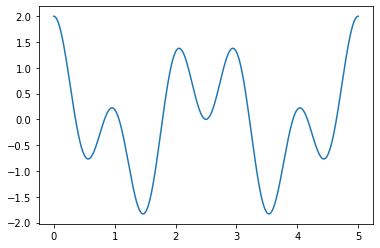

In [39]:
T=5
f=lambda t:tf.cos(2*2*np.pi*t/T)+tf.cos(5*2*np.pi*t/T)

t=tf.linspace(0,T,1000)
plt.plot(t,f(t));

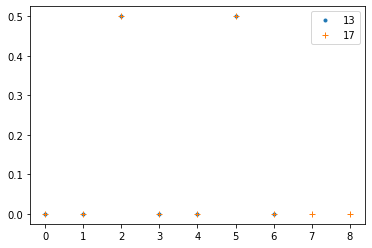

In [40]:
fig,axs=plt.subplots(1,1)
def one_spectrum(N,style):
    t=tf.cast(np.linspace(0.,T,N,endpoint=False),tf.float32)
    u=f(t)
    𝛽=tf.signal.rfft(u)/N
    axs.plot(tf.math.real(𝛽),style,label=str(N))
    axs.legend()

one_spectrum(13,".")
one_spectrum(17,"+")

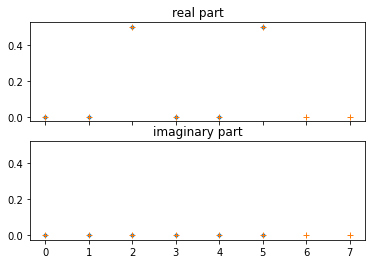

In [41]:
fig,axs=plt.subplots(2,1,sharex="all",sharey="all")
axs[0].set_title("real part")
axs[1].set_title("imaginary part")

def one_spectrum(N,style):
    t=tf.cast(np.linspace(0.,T,N,endpoint=False),tf.complex64)
    u=f(t)
    𝛽=tf.signal.fft(u)/N
    axs[0].plot(tf.math.real(𝛽)[:N//2],style,label=str(N))
    axs[1].plot(tf.math.imag(𝛽)[:N//2],style,label=str(N))


one_spectrum(13,".")
one_spectrum(17,"+")

## Symétrisons

Notons $\check u$ le symétrisé d'un vecteur ou d'une fonction. 
\begin{align}
\check f(t) &= 
\begin{cases} 
f(t)   &\text{ si } t\in[0,T[\\
f(T-t) &\text{ si } t>\in [T,2T[\\
\end{cases}\\
\check u(i) &= 
\begin{cases} 
u(i)   &\text{ si } n\in [0:N-1]\\
u(N-i) &\text{ si } n\in [N:2N-1]\\
\end{cases}
\end{align} 
Propriété: 



In [62]:
a=tf.constant([1,2,3,4])
a[1:][::-1]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([4, 3, 2], dtype=int32)>

(13,)
(25,)


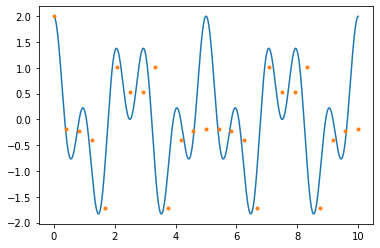

In [66]:
T=5
N=13
f=lambda t:tf.cos(2*2*np.pi*t/T)+tf.cos(5*2*np.pi*t/T)

t=tf.linspace(0,T,1000)
t_N=tf.cast(np.linspace(0,T,N,endpoint=False),tf.float32)

def sym(y):
    return tf.concat([y,y[1:][::-1]],axis=0)

check_f_t=sym(f(t))    
plt.plot(tf.linspace(0,2*T,len(check_f_t)),check_f_t);

u=f(t_N)
print(u.shape)
check_u=sym(u)
print(check_u.shape)

plt.plot(tf.linspace(0,2*T,len(check_u)),check_u,".");







Considérons $\mathcal T_N$ La transformation qui associe à chaque fonction $f$ la transformée de fourier disctère de s

Considérons $\beta_0,...,\beta_{2N-1}$ les coefficients de fourier discret de $\check u$. 

$$
\mathcal T_N [f] \to  
$$


La famille de transformation:
$$
\mathcal T_\bullet [f] \to  
$$




